# IBM Quantum challenge 2019 - write up - team Gate42#

First, let us import/initialize the stuff we will use later in the notebook.

In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.circuit import Qubit
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

from numpy import pi, arccos, sqrt

import operator
from collections import OrderedDict
from typing import Callable, List, Tuple, Union

StateInitializerType = Callable[[int], QuantumCircuit]
OracleType = Callable[[int, int], QuantumCircuit]

We will use two qubit to represent each district (vertex of the graph) in the quantum circuit. The state of the two qubits will hold the color of that distric. In the quantum circuit, we will represent only the districts 0 to 6 (included). We do not need to represent the pre-colored districts. 

According to the challenge statement, we are given a 32-qubit machine (a simulator), so we have an upper bound on the number of qubits we can use to solve the problem. Here is a short description of how we have used the 32 qubits of the given machine for our solution. 

| Qubit(s) | Type | Usage   |
|------|------|------|
|  \[0-13\]  | state | to represent the konbinis in districts 0 to 6 |
| \[14-19\] | ancilla | to store results of color check within an edge group \* |
| \[20-22\] | ancilla | to store the combined result for each group of edges |
| \[23-26\] | ancilla | ancilla qubits for _mct_ gates used in the circuit \*\*|
| 27 | ancilla | the target qubit for oracle phase flip |


\* In our oracle we process the graph edges in groups, so that we can fit in the 32 qubit limit of the challenge.

\*\* The _mct_ gate with $N$ controls ($N > 2$) requires at least $N-2$ ancila qubits.

# Step 1: Grover sketch #

Here we define a function called ```grover```, which sketches the workflow of the Grover algorithm for the konbini distribution problem. 

The function accepts as arguments two quantum registers (<i>state_register</i> and <i>ancilla_register</i>), two function objects (<i>init_state</i> and <i>oracle</i>) and the number of interations (<i>iter_count</i>) to construct the entire circuit for the Grover search. The two quantum registers should be in initial/default/blank state $\vert 0^{\otimes n} \rangle $ before being passed to the function ```grover```. The callable object <i>init_state</i> and <i>oracle</i> are supposed to return a QuantumCircuit object when called, which implement the preparation of the initial state and the oracle respectively. As for <i>iter_count</i>, in general Grover's algorithm should be able to determine optimal number of iteration on its own, but since the challenge problem fixes the iteration count, we made it an argument to the function ```grover```, so that we can manually specify it.

In [144]:
def grover(state_register: QuantumRegister, ancilla_register: QuantumRegister, init_state: StateInitializerType,
           oracle: OracleType, iter_count: int):
    qc = QuantumCircuit(state_register, ancilla_register, name="Grover")
    target = ancilla_register[-1]

    # initialize the state
    init_instructions = init_state(len(state_register)).to_instruction()
    qc.append(init_instructions, state_register)

    # initialize the target (oracle phase flip) qubit
    qc.x(target)
    qc.h(target)

    for i in range(iter_count):
        #add the oracle to the circuit
        oracle_instructions = oracle()
        qc.append(oracle_instructions, state_register[:] + ancilla_register[:])

        #implement the Grover diffusion (inversion about mean) on the state registers
        qc.append(init_instructions.inverse(), state_register)
        qc.x(state_register)
        
        qc.h(state_register[-1])
        qc.mct(state_register[:-1], state_register[-1], ancilla_register[:len(state_register) - 3])
        qc.h(state_register[-1])

        qc.x(state_register)
        qc.append(init_instructions, state_register)

    # print("Grover part: \n", qc)

    return qc

# Step 2: Construct the state initializer #

Throughout this notebook, we will refer to the vertices which are already colored in the problem statement as 'external' ones. Because of these external vertices in the graph, we already know from the beginning right away, that some color combinations are not solutions to our problem, e.g. district 0 can never have color A, or district 5 cannot have color D, etc. Hence, for the grover search, instead of preparing a uniform superposition of all possible color combinations, we can exclude the states known not to be solutions, and thus reduce the size of the search space. For this purpose, let us define four functions, which can initialize a two-qubit state into a superposition state where all participating states have equal amplitudes, except one, which has amplitude equal to zero (i.e. a uniform superposition of states where one of all possible states is missing). E.g. instead of initializing the two qubits representing the vertex 6 to $\frac{1}{\sqrt{4}}(\vert 00 \rangle + \vert 01 \rangle + \vert 10 \rangle +\vert 11 \rangle)$ we want to initialize it to $\frac{1}{\sqrt{3}}(\vert 00 \rangle + \vert 01 \rangle + \vert 10 \rangle \rangle)$.

In [16]:
THETA = 2 * arccos(1 / sqrt(3))

def get_not_00_state():
    register = QuantumRegister(2)
    qc = QuantumCircuit(register, name='not_A')
    qc.ry(pi - THETA, 0)
    qc.x(1)
    qc.cx(0, 1)
    qc.ch(1, 0)

    return qc


def get_not_01_state():
    register = QuantumRegister(2)
    qc = QuantumCircuit(register, name='not_B')
    qc.ry(THETA, 0)
    qc.ch(0, 1)

    return qc


def get_not_10_state():
    register = QuantumRegister(2)
    qc = QuantumCircuit(register, name='not_C')
    qc.ry(THETA, 1)
    qc.ch(1, 0)

    return qc


def get_not_11_state():
    register = QuantumRegister(2)
    qc = QuantumCircuit(register, name='not_D')
    qc.ry(pi - THETA, 0)
    qc.x(0)
    qc.ch(0, 1)
    qc.x(0)

    return qc

#wrapper function
def get_reduced_superposition_state_circuit(state: str):
    if state == "00":
        return get_not_00_state()
    elif state == "01":
        return get_not_01_state()
    elif state == "10":
        return get_not_10_state()
    elif state == "11":
        return get_not_11_state()

    raise ValueError()

Let us draw one of these circuits.

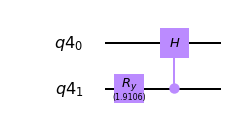

In [17]:
qc = get_reduced_superposition_state_circuit('10')
qc.draw(output='mpl')

For further convenience we define a class to represent a konbini as follows

    """
    A class to represent a Konbini object.

    Properties:
        name: one of KONBINI_NAMES
        encoding: the binary encoding of the konbini color
        color: color corresponding to the konbini name. Corresponding entry in COLORS
    """

In [25]:
KONBINI_NAMES = ['A', 'B', 'C', 'D']
COLORS = ['RED', 'BLUE', 'GREEN', 'YELLOW']


class Konbini:
    name: str
    encoding: str
    color: str

    def __init__(self, name: str, color: str, encoding: str):
        self.name = name
        self.encoding = encoding
        self.color = color

    def __eq__(self, other: 'Konbini'):
        return other.encoding == self.encoding

    @staticmethod
    def get_by_name(name):
        number = KONBINI_NAMES.index(name)
        return Konbini(name, COLORS[number], "{0:02b}".format(number))

    def __str__(self):
        return f"Konbini {self.name}"

    def __repr__(self):
        return self.__str__()

A class to represent a vertex in a graph:

    """
    A class to represent a Vertex in a graph.

    Properties:
        graph: the graph object to which this vertex corresponds to
        number: the numerical representation of the vertex in the graph
        konbini: the Konbini available in this vertex
        neighbours: list of adjacent vertices
    """

In [26]:
class Vertex:
    graph: 'Graph'
    number: Union[int, None]
    konbini: Konbini
    neighbours: List['Vertex']

    def __init__(self, graph: 'Graph', number: Union[int, None]):
        self.graph = graph
        self.number = number
        self.konbini = None
        self.neighbours = []

    def is_external(self) -> bool:
        return self.number is None

    def add_neighbour(self, neighbour: 'Vertex'):
        self.neighbours.append(neighbour)

    def get_qubits(self, state_register: Union[QuantumRegister, List[Qubit]]) -> List[Qubit]:
        return state_register[self.number * self.graph.color_bit_length:self.number * self.graph.color_bit_length + self.graph.color_bit_length]

    def __str__(self):
        if self.number is None:
            return f"ExternalVertex {self.konbini.name}"
        return f"Vertex {self.number}"

    def __repr__(self):
        return self.__str__()

    def __eq__(self, other: 'Vertex'):
        return other.number == self.number

and a class to represent a graph

In [60]:
class Graph:
    color_bit_length: int = 2
    largest_number_of_neighbours: int = 0
    largest_group_size: int = 0
    vertices: List[Vertex]
    edges: List[Tuple[Vertex, Vertex]]
    external_edges: List[Tuple[Konbini, Vertex]]
    groups: List[List[Tuple[Vertex, Vertex]]]
    state_finalizer = None

    def __init__(self, number_of_vertices: int, edges: List[Tuple[int, int]],
                 external_edges: List[Tuple[Konbini, int]] = None):
        self.vertices = [Vertex(self, i) for i in range(number_of_vertices)]
        self.edges = []
        self.groups = []

        for start, end in edges:
            self._add_edge(start, end)

        if external_edges is None:
            external_edges = []
        self.external_edges = []

        for konbini, index in external_edges:
            self._add_external_edge(konbini, index)

        for vertex in self.vertices:
            if len(vertex.neighbours) > self.largest_number_of_neighbours:
                self.largest_number_of_neighbours = len(vertex.neighbours)

            if len(vertex.neighbours) > 0:
                self.groups.append([(vertex, neighbour) for neighbour in vertex.neighbours])

        self.largest_group_size = self.largest_number_of_neighbours

    def _add_edge(self, start: int, end: int):
        if end < start:
            tmp = end
            end = start
            start = tmp

        self.vertices[start].add_neighbour(self.vertices[end])
        self.edges.append((self.vertices[start], self.vertices[end]))

    def _add_external_edge(self, konbini: Konbini, index: int):
        if konbini.encoding == "00":
            external_vertex = Vertex(self, None)
            external_vertex.konbini = konbini
            self.vertices[index].add_neighbour(external_vertex)
            self.edges.append((self.vertices[index], external_vertex))
        else:
            self.external_edges.append((konbini, self.vertices[index]))

    def redefine_groups(self, groups: List[List[Tuple[int, Union[int, str]]]]):
        """
        By default (see __init__) the oracle will group all the edges by a vertex, 
        i.e all edges having the vertex 0 will be one group, all edges
        having the vertex 1 (excluding (0, 1)) will be another group, etc.
        This function will redefine the grouping based on the groups argument.
        """
        new_groups = []
        largest_group_size = 0

        for group in groups:
            new_group = []
            for edge in group:
                start, end = edge

                if isinstance(end, str):
                    for neighbour in self.vertices[start].neighbours:
                        if neighbour.is_external() and neighbour.konbini.name == end:
                            new_group.append((self.vertices[start], neighbour))
                            break
                    else:
                        raise ValueError()
                else:
                    new_group.append((self.vertices[start], self.vertices[end]))

            new_groups.append(new_group)
            if len(new_group) > largest_group_size:
                largest_group_size = len(new_group)

        self.groups = new_groups
        self.largest_group_size = largest_group_size

    def get_all_possible_state_preparing_circuit_initializer(self) -> StateInitializerType:
        def initializer(size: int) -> QuantumCircuit:
            state_register = QuantumRegister(size)
            qc = QuantumCircuit(state_register, name="State Init")
            vertices_initialized = [False for i in range(len(self.vertices))]

            for konbini, vertex in self.external_edges:
                init_state_circuit = get_reduced_superposition_state_circuit(konbini.encoding)
                qc.append(init_state_circuit, vertex.get_qubits(state_register))
                vertices_initialized[vertex.number] = True

            for vertex in self.vertices:
                if not vertices_initialized[vertex.number]:
                    qc.h(vertex.get_qubits(state_register))

            # print("Graph state init: \n", qc)

            return qc

        return initializer

    def get_additional_restrictions_circuit(self, vertex: Vertex, external_vertex: Vertex) -> QuantumCircuit:
        if not external_vertex.is_external() or external_vertex.konbini.encoding != "00":
            raise ValueError()

        register = QuantumRegister(self.color_bit_length)
        target_register = QuantumRegister(1)
        target = target_register[0]
        qc = QuantumCircuit(register, target_register)
        qc.x(register)
        qc.ccx(*register, target)
        qc.x(target)

        return qc

    def get_ancilla_size_needed(self):
        """
        Determine the number of ancilla bits needed, based on the grouping of edges.
        """
        group_edge_results_size = self.largest_group_size
        all_group_results_size = len(self.groups)
        mct_ancilla_size = max(group_edge_results_size, all_group_results_size) - 2
        target_register_size = 1

        return group_edge_results_size + all_group_results_size + mct_ancilla_size + target_register_size

    def color(self, color_bitstring: str):
        for i in range(len(self.vertices)):
            color_code = color_bitstring[i*self.color_bit_length:i*self.color_bit_length + self.color_bit_length]
            color_index = int(color_code, 2)

            self.vertices[i].konbini = Konbini(KONBINI_NAMES[color_index], COLORS[color_index], color_code)

    def is_coloring_valid(self):
        for start, end in self.edges:
            if start.konbini == end.konbini:
                return False

        for konbini, vertex in self.external_edges:
            if vertex.konbini == konbini:
                return False

        return True

    def get_colored(self, color_bitstring: str):
        new_graph = Graph(len(self.vertices),
                          [(start.number, end.number) for start, end in self.edges if not end.is_external()],
                          [(end.konbini, start.number) for start, end in self.edges if end.is_external()] + [
                              (konbini, vertex.number) for konbini, vertex in self.external_edges
                          ],
                          )
        new_graph.color(color_bitstring)
        return new_graph

    def set_state_finalizer(self, finalizer: Callable[['Graph'], QuantumCircuit]):
        self.state_finalizer = finalizer

    def get_state_finalization_circuit(self):
        if self.state_finalizer:
            return self.state_finalizer(self)
        else:
            register = QuantumRegister(len(self.vertices)* self.color_bit_length)
            #return QuantumCircuit(register)
            qc = QuantumCircuit(register)
            qc.x(0)
            qc.x(0)
            return qc

# Step 3: Implement the oracle #

Before implementing the main logic of the oracle, we need a function which creates a circuit to compare the colors of two vertices. The function below implmenets such a circuit and returns it, so that we can use it as a component in different parts of the global circuit.

In [28]:
def get_check_same_color_circuit(color_bitstring_size: int) -> QuantumCircuit:
    vertex1 = QuantumRegister(color_bitstring_size)
    vertex2 = QuantumRegister(color_bitstring_size)
    target_register = QuantumRegister(1)
    target = target_register[0]
    qc = QuantumCircuit(vertex1, vertex2, target_register)
    if len(vertex1) != len(vertex2):
        raise ValueError()

    for i in range(color_bitstring_size):
        qc.cx(vertex1[i], vertex2[i])

    for i in range(color_bitstring_size):
        qc.x(vertex2[i])

    qc.ccx(*vertex2, target)
    qc.x(target)

    return qc

This color comparing circuit uses one ancilla qubit to store the result, but it modifies the second color in the process, so if we need the same vertex once again, we will need to reverse the previous color check action first. In the codes below we will refer to such vertices (which need reversal to be used again) as 'spoiled vertices'.

To make it more visual, let us draw the circuit

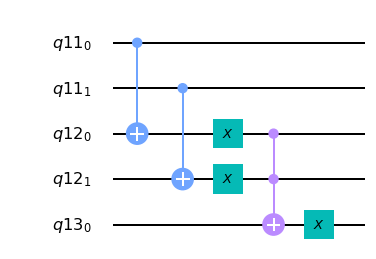

In [29]:
qc = get_check_same_color_circuit(2)
qc.draw(output='mpl')

Now we are ready to implement the oracle for our konbini problem.

In [30]:
def get_konbini_oracle(graph: Graph) -> OracleType:
    state_register = QuantumRegister(len(graph.vertices) * graph.color_bit_length)

    group_edge_results = QuantumRegister(graph.largest_group_size)
    all_group_results = QuantumRegister(len(graph.groups))

    mct_ancilla_size = max(len(group_edge_results), len(all_group_results)) - 2

    mct_ancilla = QuantumRegister(mct_ancilla_size)
    target_register = QuantumRegister(1)

    def get_edges_comparing_circuit_for_group(group: List[Tuple[Vertex, Vertex]]):
        qc = QuantumCircuit(state_register, group_edge_results, all_group_results, mct_ancilla, target_register,
                            name="Edge comparison")

        spoiled_vertex_numbers = {}
        for edge_index, edge in enumerate(group):
            vertex1, vertex2 = edge
            if vertex1.number in spoiled_vertex_numbers:
                reverse_circuit, registers = spoiled_vertex_numbers[vertex1.number]
                qc.append(reverse_circuit, registers)

            if vertex2.number in spoiled_vertex_numbers:
                reverse_circuit, registers = spoiled_vertex_numbers[vertex2.number]
                qc.append(reverse_circuit, registers)

            if vertex2.is_external():
                additional_restrictions_circuit = graph.get_additional_restrictions_circuit(vertex1, vertex2)
                vertex_registers = vertex1.get_qubits(state_register)
                check_registers = vertex_registers + [group_edge_results[edge_index]]
                qc.append(additional_restrictions_circuit, check_registers)
                spoiled_vertex_numbers[vertex1.number] = additional_restrictions_circuit.inverse(), check_registers
            else:
                check_same_color_circuit = get_check_same_color_circuit(graph.color_bit_length)

                vertex_registers = vertex1.get_qubits(state_register) + vertex2.get_qubits(state_register)
                check_registers = vertex_registers + [group_edge_results[edge_index]]
                qc.append(check_same_color_circuit, check_registers)
                spoiled_vertex_numbers[vertex2.number] = check_same_color_circuit.inverse(), check_registers

        return qc

    def get_all_groups_comparing_circuit():
        all_registers = state_register[:] + group_edge_results[:] + all_group_results[:] + mct_ancilla[:] + target_register[:]

        qc = QuantumCircuit(state_register, group_edge_results, all_group_results, mct_ancilla, target_register,
                            name="Group comparison")

        for group_index, group in enumerate(graph.groups):
            edges_comparing_circuit = get_edges_comparing_circuit_for_group(group)

            qc.append(edges_comparing_circuit, all_registers)

            qc.mct(
                group_edge_results[:len(group)],
                all_group_results[group_index],
                mct_ancilla[:]
            )

            if group_index != len(graph.groups) - 1:
                qc.append(edges_comparing_circuit.inverse(), all_registers)

        return qc

    def oracle() -> QuantumCircuit:
        target = target_register[0]
        all_ancilla_qubits = group_edge_results[:] + all_group_results[:] + mct_ancilla[:] + target_register[:]

        qc = QuantumCircuit(state_register, group_edge_results, all_group_results, mct_ancilla, target_register,
                            name="Oracle")

        compare_all_vertices_circuit = get_all_groups_comparing_circuit()
        apply_to_register = state_register[:] + all_ancilla_qubits

        qc.append(compare_all_vertices_circuit, apply_to_register)

        qc.mct(
            all_group_results,
            target,
            mct_ancilla
        )

        qc.append(compare_all_vertices_circuit.inverse(), apply_to_register)

        return qc

    return oracle

# Step 4: Collect the puzzle #

We now stick all the pieces implemented above together, add a finalizer (...) and the measurements to the circuit.

In [37]:
def run_coloring_grover(graph: Graph, iter_count: int):
    state_size = len(graph.vertices) * graph.color_bit_length
    state_register = QuantumRegister(state_size)
    ancilla_register = QuantumRegister(graph.get_ancilla_size_needed())
    results_register = ClassicalRegister(state_size)
    qc = QuantumCircuit(state_register, ancilla_register, results_register)

    grover_instructions = grover(state_register, ancilla_register,
                                 graph.get_all_possible_state_preparing_circuit_initializer(),
                                 get_konbini_oracle(graph), iter_count)

    qc.append(grover_instructions, state_register[:] + ancilla_register[:])

    finalizer_circuit = graph.get_state_finalization_circuit()
    qc.append(finalizer_circuit, state_register[:])

    qc.measure(state_register, results_register)

    return qc

# Step 5: Test the circuit #

Before running the circuit against the konbini graph in the hackathon problem we would like to run it on some smaller graphs, and simulate locally, to verify that the code is working.

Let us first define a function which will run a given quantum circuit on a local qasm simulator and print the results

In [38]:
def run_and_print_results(qc: QuantumCircuit):
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=1000)
    result = job.result()
    counts = result.get_counts(qc)
    sorted_counts = OrderedDict(sorted(counts.items(), key=operator.itemgetter(1))[::-1])

    print([(k[::-1], c) for k, c in sorted_counts.items()])

    return sorted_counts

And let us define a simple graph with 4+2 vertces (2 external ones, 4 non colored ones), and then run the algorithm and verify the results.

In [59]:
def get_4_vertex_graph():
    return Graph(4, [
        (0, 1),
        (1, 2),
        (2, 3),
        (3, 0),
        (0, 2),
    ], [
        (Konbini.get_by_name('A'), 0),
        (Konbini.get_by_name('D'), 1),
    ])

In [63]:
graph = get_4_vertex_graph()
qc = run_coloring_grover(graph, 2)
results = run_and_print_results(qc)
most_probable = list(results.keys())
valid_total_solutions = 0
number_of_valid_states_found = 0
found_invalid = False

for color_bitstring in most_probable:
    color_bitstring_corrected = color_bitstring[::-1]
    colored = graph.get_colored(color_bitstring_corrected)
    if not colored.is_coloring_valid():
        found_invalid = True
        #print(f"Not valid coloring: {color_bitstring_corrected} with count of {results[color_bitstring]}")
    else:
        valid_total_solutions += 1

    if not found_invalid:
        number_of_valid_states_found += 1

print(f"Total valid solutions: {valid_total_solutions}")
print(f"From which algorithm found: {number_of_valid_states_found}")

[('11010010', 40), ('01100011', 40), ('11100110', 37), ('01001100', 37), ('11010001', 36), ('11011000', 35), ('10001101', 35), ('10010011', 35), ('01001110', 34), ('11000110', 34), ('11100100', 33), ('01101100', 32), ('11000100', 31), ('01001011', 31), ('01100010', 31), ('01101110', 30), ('10011100', 30), ('01001000', 29), ('11001000', 29), ('10010001', 29), ('11011001', 28), ('11001001', 27), ('10011101', 27), ('10000100', 27), ('10001100', 27), ('11100010', 22), ('11100001', 21), ('10000111', 19), ('00001011', 4), ('00101111', 3), ('00100101', 3), ('10100001', 3), ('11000111', 3), ('01010101', 3), ('01001001', 3), ('00001001', 2), ('00101000', 2), ('00000001', 2), ('00100111', 2), ('11011011', 2), ('00000000', 2), ('10001111', 2), ('00011010', 2), ('10100011', 2), ('00010001', 2), ('11101010', 2), ('10000011', 2), ('01010111', 2), ('00101001', 2), ('01011001', 2), ('01000001', 2), ('10001010', 2), ('01000111', 2), ('01000000', 2), ('11101011', 2), ('01011000', 2), ('01011010', 2), ('

# Step 6: The hackathon circuit #

We now define a function to create the graph for the hackathon problem, and make a quantum circuit out of it.

In [145]:
def get_ibm_graph() -> Graph:
    KONBINI_A = Konbini.get_by_name('A')
    KONBINI_B = Konbini.get_by_name('B')
    KONBINI_C = Konbini.get_by_name('C')
    KONBINI_D = Konbini.get_by_name('D')
    tmp = KONBINI_A.encoding
    KONBINI_A.encoding = KONBINI_C.encoding
    KONBINI_C.encoding = tmp

    graph = Graph(7, [
        (0, 1), (0, 2), (0, 3), (1, 3),
        (1, 4), (2, 3), (2, 5), (2, 6),
        (3, 4), (3, 5), (3, 6),
        (4, 6), (5, 6),
    ], [
        (KONBINI_A, 0),
        (KONBINI_B, 1),
        (KONBINI_A, 2),
        (KONBINI_C, 2),
        (KONBINI_A, 3),
        (KONBINI_B, 4),
        (KONBINI_D, 5),
        (KONBINI_D, 6)
    ])

    def get_finalizer_circuit(graph: Graph):
        register = QuantumRegister(len(graph.vertices) * graph.color_bit_length)
        qc = QuantumCircuit(register)

        for vertex in graph.vertices:
            qc.x(vertex.get_qubits(register)[1])
            qc.cx(vertex.get_qubits(register)[1], vertex.get_qubits(register)[0])
            qc.x(vertex.get_qubits(register)[1])

        return qc

    graph.set_state_finalizer(get_finalizer_circuit)

    graph.redefine_groups([
        [(0, 1), (6, 4), (6, 5)],  # 1, 4, 5
        [(2, 0), (2, 5), (2, 6), (2, 'C'), (1, 4)],  # 0, 5, 6, 2, 4
        [(3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6)],  # 0, 1, 2, 4, 5, 6
    ])

    return graph


def get_hackathon_circuit():
    graph = get_ibm_graph()
    qc = run_coloring_grover(graph, 5)
    return qc

def get_cost(qc: QuantumCircuit) -> int:
    pass_ = Unroller(['u3', 'cx'])
    pm = PassManager(pass_)
    new_circuit = pm.run(qc)
    counts = new_circuit.count_ops()
    cost = counts["u3"] + 10 * counts['cx']

    print(counts)

    return cost

And we can see that the cost of the circuit is 34269.

In [146]:
qc = get_hackathon_circuit()
get_cost(qc)

Ancilla register size: 14
OrderedDict([('u3', 5429), ('cx', 2884), ('measure', 14)])


34269

The output of the execution of this circuit on the IBM Q 32 qubit simulator during the hackathon gave the following output

```{"ans": [["02313102023", 241], ["02013132023", 234], ["02013122203", 233], ["02011322203", 231], ["02013132203", 225], ["01013232013", 224], ["02313122203", 218], ["01313202013", 218], ["01013232103", 217]], "costs": {"u3": 5905, "cx": 3155, "measure": 14}}```